In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resume-dataset/Resume/Resume.csv
/kaggle/input/resume-dataset/data/data/DESIGNER/22506245.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/13998435.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/67582956.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/34349255.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/26790545.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/12674307.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/11807040.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/44145704.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/27497542.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/11155153.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/17555081.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/41506705.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/54201930.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/24583187.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/38565119.pdf
/kaggle/input/resume-dataset/data/data

# Cell 1: Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Download stopwords if not already available
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Cell 2: Load and Inspect Data

In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')

# Display the first five rows
df.head()


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Cell 3: Check for Missing Values

In [4]:
# Check for missing values
df.isnull().sum()


ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

# Cell 4: Data Cleaning Function

In [9]:
# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
        return text
    return ""

# Apply cleaning to the 'resume_str' column
df['clean_resume'] = df['Resume_str'].apply(clean_text)

# Display cleaned data
df[['Resume_str', 'clean_resume']].head()


,Resume_str,clean_resume
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,hr administratormarketing associate hr adminis...
1,"HR SPECIALIST, US HR OPERATIONS ...",hr specialist us hr operations summary versati...
2,HR DIRECTOR Summary Over 2...,hr director summary years experience recruitin...
3,HR SPECIALIST Summary Dedica...,hr specialist summary dedicated driven dynamic...
4,HR MANAGER Skill Highlights ...,hr manager skill highlights hr skills hr depar...


# Cell 5: Convert Category to Numeric Labels

In [10]:
# Encode category labels into numbers
df['category_label'] = df['Category'].astype('category').cat.codes

# Display the mapping of labels
category_mapping = dict(enumerate(df['Category'].astype('category').cat.categories))
print(category_mapping)


{0: 'ACCOUNTANT', 1: 'ADVOCATE', 2: 'AGRICULTURE', 3: 'APPAREL', 4: 'ARTS', 5: 'AUTOMOBILE', 6: 'AVIATION', 7: 'BANKING', 8: 'BPO', 9: 'BUSINESS-DEVELOPMENT', 10: 'CHEF', 11: 'CONSTRUCTION', 12: 'CONSULTANT', 13: 'DESIGNER', 14: 'DIGITAL-MEDIA', 15: 'ENGINEERING', 16: 'FINANCE', 17: 'FITNESS', 18: 'HEALTHCARE', 19: 'HR', 20: 'INFORMATION-TECHNOLOGY', 21: 'PUBLIC-RELATIONS', 22: 'SALES', 23: 'TEACHER'}


# Cell 6: Train-Test Split

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_resume'], df['category_label'], test_size=0.2, random_state=42)

# Print dataset shapes
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 1987, Testing samples: 497


# Cell 7: Convert Text Data to TF-IDF Vectors

In [12]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Transform text data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Display the shape of the feature matrix
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")


TF-IDF feature matrix shape: (1987, 5000)


# Cell 8: Train Support Vector Machine (SVM) Model

In [14]:
# Initialize and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_tfidf)


# Cell 9: Evaluate Model Performance

In [15]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=category_mapping.values()))


Model Accuracy: 0.6318

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.81      0.86      0.83        29
              ADVOCATE       0.53      0.63      0.58        30
           AGRICULTURE       0.20      0.12      0.15         8
               APPAREL       0.47      0.40      0.43        20
                  ARTS       0.11      0.11      0.11        18
            AUTOMOBILE       1.00      0.33      0.50         6
              AVIATION       0.72      0.86      0.78        21
               BANKING       0.71      0.65      0.68        23
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.79      0.56      0.65        27
                  CHEF       0.84      0.67      0.74        24
          CONSTRUCTION       0.89      0.74      0.81        34
            CONSULTANT       0.47      0.35      0.40        20
              DESIGNER       0.76      0.84      0.80  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Cell 10: Plot Confusion Matrix

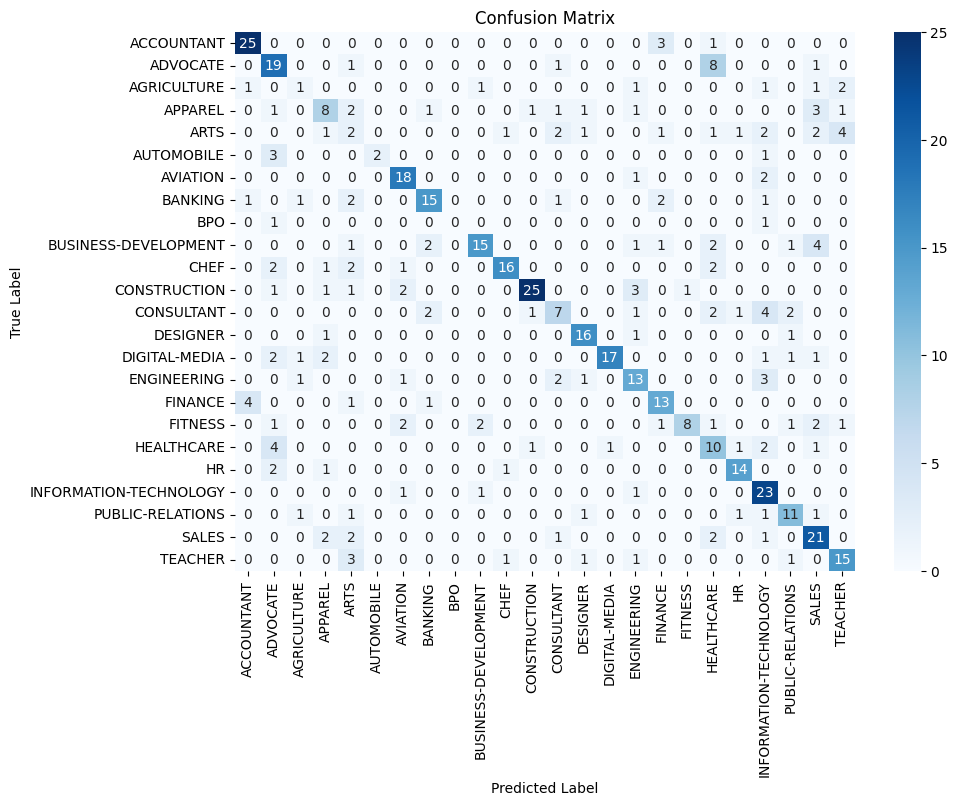

In [16]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Cell 11: Calculate Precision, Recall, and F1 Score

In [17]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("Evaluation Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")


Evaluation Metrics:
Accuracy  : 0.6318
Precision : 0.6541
Recall    : 0.6318
F1 Score  : 0.6296


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
